# Lab 7:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the Keras package
We begin by loading keras and the other packages

In [1]:
import keras
import tensorflow


Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [4]:
import requests
fn ="SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn
f=requests.get(url)
print(url)
print(f)

# TODO:  Load the file from url and save it in a file under the name fn

http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/SopSax.Vib.pp.C6Eb6.aiff
<Response [200]>


Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [5]:
# TODO test
fn = "SopSax.Vib.pp.C6Eb6.aiff"
y, sr = librosa.load(fn)
print(y,sr)

[ 0.          0.          0.         ... -0.00370684 -0.00432387
  0.        ] 22050


Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

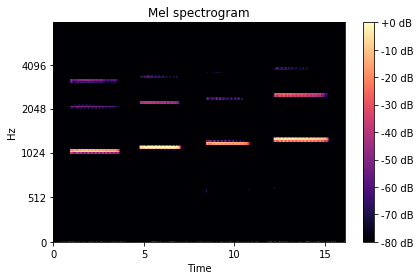

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [8]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class.


In [9]:
# TODO
# What are the number of training and test samples?
# print(Xtr)
# print(ytr.shape)
features=Xts.shape[1]
# print(yts.shape)
train=(Xtr.shape+ytr.shape)[0]
# print(train)
test=(Xts.shape+yts.shape)[0]
# print(test)
print("There are {} Traning and {} Testing Sets".format(train,test))
# What is the number of features for each sample?
print("There are {} features for each sample".format(features))
# How many classes (i.e. instruments) are there per class.
print("There are {} instruments?".format(features))

There are 66247 Traning and 14904 Testing Sets
There are 120 features for each sample
There are 120 instruments?


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [10]:
from sklearn import preprocessing 
# TODO Scale the training and test matrices
Xtr_scale_1 = Xtr-Xtr.mean()/Xtr.std()
Xts_scale_1 = Xts-Xts.mean()/Xts.std()
print(Xtr_scale_1,Xts_scale_1)
Xtr_scale=preprocessing.scale(Xtr)
Xts_scale=preprocessing.scale(Xts)

[[-0.29675967 -0.29622785 -0.29339483 ... -0.28333127 -0.28330337
  -0.28592174]
 [-0.29675639 -0.29613603 -0.29327282 ... -0.27735453 -0.27214381
  -0.27740912]
 [-0.29674411 -0.29618175 -0.29318776 ... -0.27897647 -0.26715786
  -0.27669354]
 ...
 [-0.29691701 -0.29684687 -0.29650208 ... -0.16201789 -0.17840626
  -0.19277663]
 [-0.29692252 -0.29685228 -0.29650743 ... -0.15287946 -0.12672588
  -0.2014566 ]
 [-0.29692452 -0.29685446 -0.29650379 ... -0.23609909 -0.23402442
  -0.24417535]] [[-0.27486479 -0.27419062 -0.2710149  ... -0.27224458 -0.27446456
  -0.27107516]
 [-0.27487112 -0.27421947 -0.2711372  ... -0.27375314 -0.27230253
  -0.27252239]
 [-0.27484222 -0.27416989 -0.271      ... -0.27158228 -0.27438006
  -0.27015614]
 ...
 [-0.27504846 -0.27492011 -0.27429009 ... -0.27403259 -0.27297486
  -0.27303949]
 [-0.27504742 -0.27491892 -0.27429656 ... -0.26928129 -0.27078206
  -0.26684026]
 [-0.27504685 -0.2749223  -0.27429589 ... -0.26790901 -0.26850091
  -0.26900391]]


## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation
* select the input and output shapes correctly
* print the model summary

In [11]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [12]:
# TODO clear session
keras.backend.clear_session()

In [13]:
# TODO: construct the model

ni=Xtr_scale.shape[1]
nh=256
no=int(np.max(ytr)+1)

#Begin
model=Sequential()

#Hidden
model.add(Dense(nh,input_shape=(ni,),activation="sigmoid",name="hidden"))

#output
model.add(Dense(no,activation="sigmoid",name="output"))

In [14]:
# TODO:  Print the model summary
# model.compile( optimizer='sgd',loss='mean_squared_error')
# model.fit(Xtr_scale, ytr, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________
None


To keep track of the loss history and validation accuracy, we will use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).  A callback is a class that is passed to the `fit` method.  Complete the `LoadHistory` callback class below to save the loss and validation accuracy.

In [21]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss=[]
        self.val_acc=[]
 
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
        
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [22]:
# TODO
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  Use a batch size of 100.  Your final accuracy should be >99%.

In [23]:
# TODO
batch_size = 100

model.fit(Xtr_scale, ytr,epochs=10, batch_size=batch_size, validation_data=(Xts_scale,yts),callbacks=[history_cb])

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 1s 20us/step - loss: 0.3606 - acc: 0.9057 - val_loss: 0.1722 - val_acc: 0.9563
Epoch 2/10
66247/66247 [==============================] - 1s 15us/step - loss: 0.0915 - acc: 0.9785 - val_loss: 0.1264 - val_acc: 0.9574
Epoch 3/10
66247/66247 [==============================] - 1s 14us/step - loss: 0.0552 - acc: 0.9871 - val_loss: 0.1523 - val_acc: 0.9417
Epoch 4/10
66247/66247 [==============================] - 1s 13us/step - loss: 0.0393 - acc: 0.9901 - val_loss: 0.1274 - val_acc: 0.9532
Epoch 5/10
66247/66247 [==============================] - 1s 13us/step - loss: 0.0301 - acc: 0.9920 - val_loss: 0.1574 - val_acc: 0.9381
Epoch 6/10
66247/66247 [==============================] - 1s 14us/step - loss: 0.0241 - acc: 0.9938 - val_loss: 0.1455 - val_acc: 0.9434
Epoch 7/10
66247/66247 [==============================] - 1s 14us/step - loss: 0.0198 - acc: 0.9950 - val_loss: 0.1827 - val_acc

Plot the validation accuracy saved in the `history_cb`. This gives one accuracy value per epoch.  You should see that the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

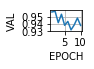

In [25]:
# TODO
ep=[i for i in range(1,11)]
plt.subplot(991)
plt.plot(ep,history_cb.val_acc)
plt.xlabel("EPOCH")
plt.ylabel("VAL")
plt.grid(True)

Plot the loss values saved in the `history_cb` class.  Use the `semilogy` plot.  There is one loss value per step.  But, plot the x-axis in epochs.  Note that the epoch in step `i` is `epoch = i*batch_size/ntr` where `batch_size` is the batch_size and `ntr` is the total number of training samples.

Text(0,0.5,'VAL')

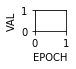

In [29]:
# TODO
import matplotlib.pyplot as plt
batch_size=100
ntr=6247
ep=[i for i in range(1,11)]
ep=[i*batch_size/ntr for i in range(1,11)]
plt.plot(ep,history_cb.val_acc)
# plt.xlabel("EPOCH")
# plt.ylabel("VAL")
plt.subplot(992)
# plt.semilogy(ep, ep*batch_size/ntr)
# plt.title('semilogy')
plt.grid(True)
plt.xlabel("EPOCH")
plt.ylabel("VAL")


## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying three learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model
* save the accuracy and losses

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 1s 17us/step - loss: 0.1088 - acc: 0.9646 - val_loss: 0.1698 - val_acc: 0.9353
Epoch 2/10
66247/66247 [==============================] - 1s 13us/step - loss: 0.0280 - acc: 0.9907 - val_loss: 0.2257 - val_acc: 0.9285
Epoch 3/10
66247/66247 [==============================] - 1s 15us/step - loss: 0.0243 - acc: 0.9922 - val_loss: 0.1864 - val_acc: 0.9396
Epoch 4/10
66247/66247 [==============================] - 1s 14us/step - loss: 0.0195 - acc: 0.9936 - val_loss: 0.3163 - val_acc: 0.9157
Epoch 5/10
66247/66247 [==============================] - 1s 13us/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.2303 - val_acc: 0.9441
Epoch 6/10
66247/66247 [==============================] - 1s 14us/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.1792 - val_acc: 0.9561
Epoch 7/10
66247/66247 [==============================] - 1s 13us/step - loss: 0.0136 - acc: 0.9956 - val_loss: 0.3480 - val_acc

Loss [[2.255917, 1.9124545, 1.7278808, 1.5969777, 1.5437388, 1.3048863, 1.3513172, 1.1569768, 1.053401, 1.0134776, 0.8840416, 0.911516, 0.7367252, 0.8282182, 0.6909163, 0.65676606, 0.5731403, 0.4969203, 0.4519279, 0.645934, 0.4681965, 0.39419624, 0.44562522, 0.3608893, 0.40731993, 0.52135545, 0.3032064, 0.51053995, 0.33491057, 0.32264218, 0.4207141, 0.26754624, 0.26403588, 0.27858245, 0.26804292, 0.20686708, 0.2371243, 0.27131748, 0.35489222, 0.21450187, 0.24528213, 0.204375, 0.37387162, 0.25298184, 0.17240258, 0.18898815, 0.23489815, 0.17874274, 0.1925439, 0.2767512, 0.22640179, 0.21924828, 0.19776441, 0.2029528, 0.18902498, 0.1586621, 0.20819472, 0.15576378, 0.09604036, 0.15326379, 0.19687136, 0.24646814, 0.1869675, 0.21402864, 0.1620294, 0.10752747, 0.10670068, 0.1459929, 0.16397196, 0.14061272, 0.20224041, 0.19404948, 0.27976972, 0.16400167, 0.17736235, 0.10481462, 0.19302173, 0.18159433, 0.11743, 0.17392044, 0.1507543, 0.13551472, 0.15454958, 0.13223024, 0.13974303, 0.15096474, 0.

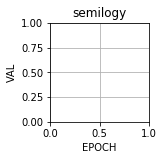

In [34]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
val_acc_hist = []


x=201

def make_graph(x):
    x+=10
    plt.subplot(x)
    batch_size=100
    ntr=6247
    ep=[i for i in range(1,11)]
    ep=[i*batch_size/ntr for i in range(1,11)]
#     plt.semilogy(ep, ep*batch_size/ntr)
    plt.title('semilogy')
    plt.grid(True)
    plt.xlabel("EPOCH")
    plt.ylabel("VAL")
    return x+1


for i in rates:
    # TODO
    keras.backend.clear_session()
    # TODO: construct the model

    ni=Xtr_scale.shape[1]
    nh=256
    no=int(np.max(ytr)+1)

    #Begin
    model=Sequential()

    #Hidden
    model.add(Dense(nh,input_shape=(ni,),activation="sigmoid",name="hidden"))

    #output
    model.add(Dense(no,activation="sigmoid",name="output"))
    # TODO
    opt = keras.optimizers.Adam(lr=i)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # TODO
    batch_size = 100
    model.fit(Xtr_scale, ytr,epochs=10, batch_size=batch_size, validation_data=(Xts_scale,yts),callbacks=[history_cb])
    loss_hist.append(history_cb.loss)
    val_acc_hist.append(history_cb.val_acc)
    x=make_graph(x)
    
    
print("Loss",loss_hist)
print("Val_acc",val_acc_hist)



Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.

In [ ]:
# TODO